In [38]:
import matplotlib.pyplot as plt
import numpy as np
import json

In [39]:
# Load 'fitness' history from file.txt as JSON format
noGA = np.loadtxt('noGA.history.txt', delimiter=',', dtype=float)
GA_A = np.loadtxt('GA-A.history.txt', delimiter=',', dtype=float)
GA_B = np.loadtxt('GA-B.history.txt', delimiter=',', dtype=float)
iterations = np.arange(0, len(noGA))
INFEASIBLE_PENALTY = 3000

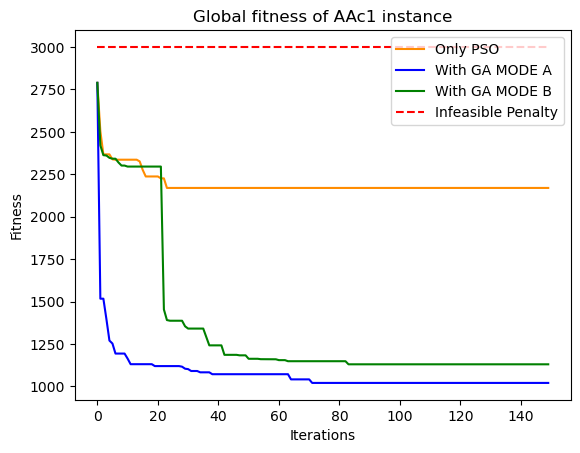

In [47]:
# Plot the fitness history
plt.plot(iterations, noGA, label='Only PSO', color='darkorange')
plt.plot(iterations, GA_A, label='With GA MODE A', color='blue')
plt.plot(iterations, GA_B, label='With GA MODE B', color='green')
plt.plot(iterations, [INFEASIBLE_PENALTY]*len(iterations), label='Infeasible Penalty', color='red', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.legend(loc='upper right')
plt.title('Global fitness of AAc1 instance')
plt.show()